# Waze User Churn Prediction Project

---

## Executive Summary

**Business Context:** Waze, a community-driven navigation app, wants to understand why users stop using their service (churn) and identify patterns that could predict which users are at risk of leaving.

**Objective:** Build a predictive model to identify users likely to churn, enabling proactive retention strategies.

**Methodology:**
1. Exploratory Data Analysis (EDA) to understand user behavior patterns
2. Statistical hypothesis testing to validate assumptions
3. Logistic regression for interpretable baseline predictions
4. Tree-based ensemble models (Random Forest, XGBoost) for improved prediction

**Key Finding:** While the models achieved ~81% accuracy, the low recall (~17% for XGBoost) indicates the current feature set has limited predictive power for identifying churned users. The analysis reveals that the dataset likely contains a high proportion of professional/long-haul drivers, whose behavior patterns may differ significantly from typical users.

---

## Table of Contents

1. Data Inspection & Understanding
2. Missing Value Analysis
3. Feature Engineering
4. Exploratory Data Analysis (EDA)
5. Hypothesis Testing
6. Binominal Logistic Regression Model
7. Machine Learning Models (Random Forest & XGBoost)
8. Conclusions & Recommendations

---

# Waze Data Analytics Project

## 1. Data Inspection & Understanding

### Purpose
Before any analysis, we need to understand what data we're working with. This foundational step examines:
- Dataset dimensions and structure
- Variable types and their meanings
- Missing value patterns
- Basic descriptive statistics

Understanding these elements ensures we make informed decisions throughout the analysis.

### 1.1 Import Core Libraries

We start with pandas for data manipulation and numpy for numerical operations. Additional libraries will be imported in their respective sections.

In [68]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

### 1.2 Load Dataset

The Waze dataset contains user behavior metrics collected over a specific time period. Each row represents a unique user.

In [70]:
#Load dataset into dataframe
df = pd.read_csv(r"\Users\shish\OneDrive\Desktop\waze_dataset.csv")

### 1.3 Preview Data Structure

Examining the first rows helps us understand the data format and identify potential issues early.

**Variable Definitions:**
| Variable | Description |
|----------|-------------|
| `ID` | Unique user identifier |
| `label` | Target: 'retained' or 'churned' |
| `sessions` | App sessions in last month |
| `drives` | Drives recorded in last month |
| `total_sessions` | Cumulative sessions since signup |
| `n_days_after_onboarding` | Days since first app use |
| `driven_km_drives` | Total km driven last month |
| `activity_days` | Days with any app activity |
| `driving_days` | Days with recorded drives |
| `device` | iPhone or Android |

In [72]:
# Show first 10 rows of the dataset
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


### 1.4 Data Types & Missing Values Overview

The `.info()` method reveals data types and null counts—critical for identifying issues that need addressing before modeling.

In [74]:
# Review the information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


## 2. Missing Value Analysis

### Purpose
The `label` column has 700 missing values (~4.7%). Before deciding how to handle these, we must determine if the missingness is random or systematic—this affects whether we can safely drop these rows.

**Analysis approach:** Compare statistics of rows WITH and WITHOUT missing labels.

In [76]:
# Isolate rows with null values
null_df = df[df['label'].isnull()]

# Display summary stats of rows with null values
null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [78]:
# Isolate rows without null values
not_null_df = df[~df['label'].isnull()]

# Display summary stats of rows without null values
not_null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Comparing summary statistics of the observations with missing retention labels with those that aren't missing any values reveals nothing remarkable. The means and standard deviations are fairly consistent between the two groups.

In [80]:
# Get count of null values by device
null_df['device'].value_counts()

device
iPhone     447
Android    253
Name: count, dtype: int64

In [82]:
# Calculate % of iPhone nulls and Android nulls
null_df['device'].value_counts(normalize=True)

device
iPhone     0.638571
Android    0.361429
Name: proportion, dtype: float64

In [84]:
# Calculate % of iPhone users and Android users in full dataset
df['device'].value_counts(normalize=True)

device
iPhone     0.644843
Android    0.355157
Name: proportion, dtype: float64

The percentage of missing values by each device is consistent with their representation in the data overall. There is nothing to suggest a non-random cause of the missing data.

In [87]:
# Calculate counts of churned vs. retained
print(df['label'].value_counts())
print()
print(df['label'].value_counts(normalize=True))

label
retained    11763
churned      2536
Name: count, dtype: int64

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64


**⚠️ Class Imbalance:** ~82% retained vs. ~18% churned. This affects model performance, especially recall for the minority class.

In [89]:
# Calculate median values of all columns for churned and retained users
df.groupby('label').median(numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


Users who churned averaged ~3 more drives in the last month than retained users, but retained users used the app on over twice as many days as churned users in the same time period.

The median churned user drove ~200 more kilometers and 2.5 more hours during the last month than the median retained user. It seems that churned users had more drives in fewer days, and their trips were farther and longer in duration. Perhaps this is suggestive of a user profile.

## 3. Feature Engineering

### Purpose
Raw features often miss behavioral patterns. Derived features can:
- Capture usage intensity (km per drive)
- Normalize metrics for fair comparison
- Create business-meaningful indicators

### 3.1 Distance & Intensity Features

In [375]:
# Add a column to df called 'km_per_drive'
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Group by 'label', calculate the median, and isolate for 'km_per_drive'
median_km_per_drive = df.groupby('label').median(numeric_only=True)[['km_per_drive']]
median_km_per_drive

,km_per_drive
label,
churned,74.109416
retained,75.014702


In [99]:
# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [101]:
# Add a column to df called 'km_per_driving_day'
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Group by 'label', calculate the median, and isolate for 'km_per_driving_day'
median_km_per_driving_day = df.groupby('label').median(numeric_only=True)[['km_per_driving_day']]
median_km_per_driving_day

df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,232.817946,inf
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,620.622351,NaN
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,3.022063e+00
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,32.424301,1.672804e+02
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,72.854343,3.231459e+02
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,179.347527,7.579257e+02
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15777.426560,inf


In [103]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

**Note:** Division by zero creates infinite values when driving_days = 0. Converting to 0 treats these as edge cases.

In [105]:
# Add a column to df called 'drives_per_driving_day'
df['drives_per_driving_day'] = df['drives'] / df['driving_days']


# Group by 'label', calculate the median, and isolate for 'drives_per_driving day'
median_drives_per_driving_day = df.groupby('label').median(numeric_only=True)[['drives_per_driving_day']]
median_drives_per_driving_day

,drives_per_driving_day
label,
churned,10.0000
retained,4.0625


In [107]:
# Convert infinite values to zero
df.loc[df['drives_per_driving_day']==np.inf, 'drives_per_driving_day'] = 0
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14992.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,232.817946,578.963113,9.387368
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,620.622351,1030.094384,19.826097
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,32.424301,136.238895,1.250000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,72.854343,272.889272,3.666667
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,179.347527,558.686918,9.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15777.426560,15420.234110,395.000000


---
### 📊 Insight: Churned Users Drive More Intensely

**Key Finding:** Churned users drive **~240% more km per driving day** than retained users.

**Interpretation:** This counterintuitive finding suggests:
1. Churned population may include many **professional/long-haul drivers**
2. High-intensity users may have different unmet expectations
3. Dataset may not represent typical casual navigation users

**Business Implication:** Retention strategies may need user-type segmentation.

---

In [110]:
# For each 'label', calculate the number of Android users and iPhone users
df.groupby(['label', 'device']).size()

label     device 
churned   Android     891
          iPhone     1645
retained  Android    4183
          iPhone     7580
dtype: int64

In [112]:
# For each 'label', calculate the percentage of Android users and iPhone users
df.groupby('label')['device'].value_counts(normalize=True)

label     device 
churned   iPhone     0.648659
          Android    0.351341
retained  iPhone     0.644393
          Android    0.355607
Name: proportion, dtype: float64

The ratio of iPhone users and Android users is consistent between the churned group and the retained group, and those ratios are both consistent with the ratio found in the overall dataset.

#### Conclusion:
1. The dataset has 700 missing values in the label column. There was no obvious pattern to the missing values.

2. The median user who churned drove 698 kilometers each day they drove last month, which is about 240% the per-drive-day distance of retained users. It would be helpful to know how this data was collected and if it represents a non-random sample of users.

3. Android users comprised approximately 36% of the sample, while iPhone users made up about 64%. The churn rate for both iPhone and Android users was within one percentage point of each other. There is nothing suggestive of churn being correlated with device.

4.  Generally, users who churned drove farther and longer in fewer days than retained users. They also used the app about half as many times as retained users over the same period.

## 4. Exploratory Data Analysis (EDA)

In [377]:
# Import additional visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
# Define the data set size
df.size

239984

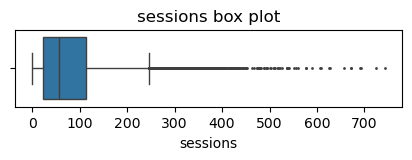

In [119]:
# Create a box plot for 'sessions' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('sessions box plot');

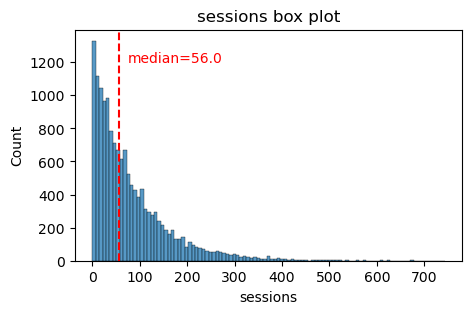

In [121]:
# Create a histogram for 'sessions' variable
plt.figure(figsize=(5,3))
sns.histplot(x=df['sessions'])
median = df['sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1200, 'median=56.0', color='red')
plt.title('sessions box plot');

The sessions variable is a right-skewed distribution with half of the observations having 56 or fewer sessions. However, as indicated by the boxplot, some users have more than 700.

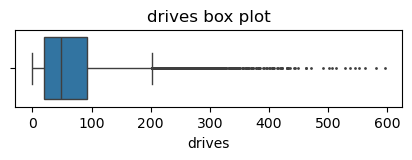

In [123]:
# Create a box plot for 'drives' variable (at least 1 km)
plt.figure(figsize=(5,1))
sns.boxplot(x=df['drives'], fliersize=1)
plt.title('drives box plot');

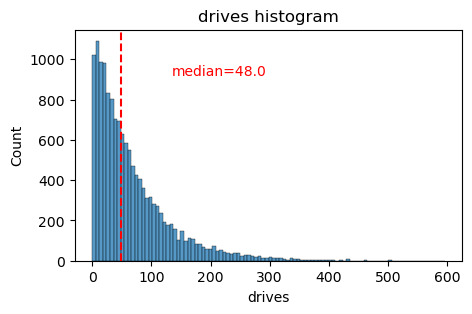

In [379]:
# Create a histogram for 'drives' variable
def histogrammer(column_str, median_text=True, **kwargs):    
                                                             
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df[column_str], **kwargs)            
    plt.axvline(median, color='red', linestyle='--')         
    if median_text==True:                                    
        ax.text(0.25, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');
histogrammer('drives')

The 'drives' information follows a distribution similar to the 'sessions' variable. It is right-skewed, approximately log-normal, with a median of 48. However, some drivers had over 400 drives in the last month.

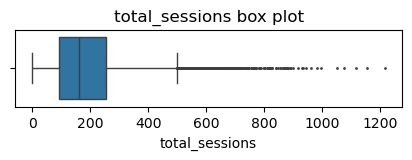

In [128]:
# Box plot for 'total_sessions' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['total_sessions'], fliersize=1)
plt.title('total_sessions box plot');

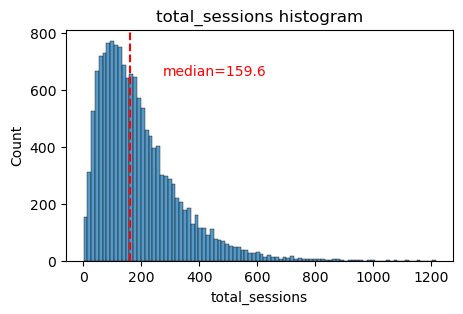

In [130]:
# Histogram for 'total_sessions' variable
histogrammer('total_sessions')

The total_sessions is a right-skewed distribution. The median total number of sessions is 159.6. This is interesting information because, if the median number of sessions in the last month was 48 and the median total sessions was ~160, then it seems that a large proportion of a user's total drives might have taken place in the last month.

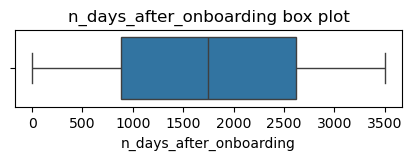

In [133]:
# Box plot for 'n_days_after_onboarding' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['n_days_after_onboarding'], fliersize=1)
plt.title('n_days_after_onboarding box plot');

Median: 1741.0


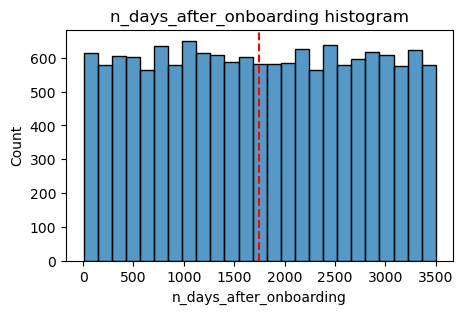

In [135]:
# Histogram for 'n_days_after_onboarding' variable
histogrammer('n_days_after_onboarding',median_text=False)

The total user tenure (i.e., number of days since
onboarding) is a uniform distribution with values ranging from near-zero to \~3,500 (\~9.5 years).

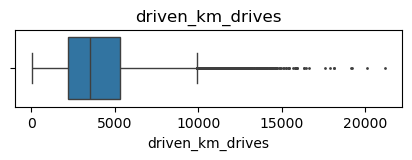

In [137]:
# Box plot for 'driven_km_drives' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driven_km_drives'], fliersize=1)
plt.title('driven_km_drives');

Median: 3493.9


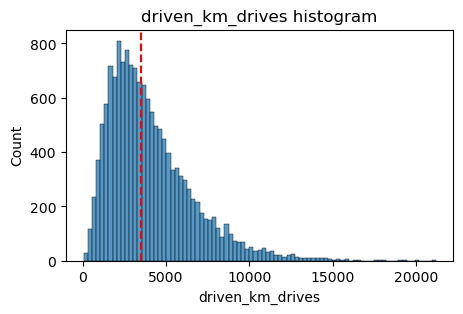

In [139]:
# Histogram for 'driven_km_drives' variable
histogrammer('driven_km_drives',median_text=False)

The number of drives driven in the last month per user is a right-skewed distribution with half the users driving under 3,495 kilometers.

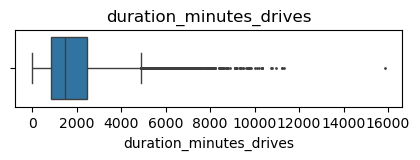

In [142]:
# Box plot for 'duration_minutes_drives' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['duration_minutes_drives'], fliersize=1)
plt.title('duration_minutes_drives');

Median: 1478.2


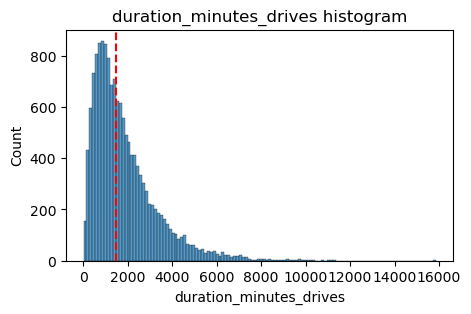

In [144]:
# Histogram for 'duration_minutes_drives' variable
histogrammer('duration_minutes_drives',median_text=False)

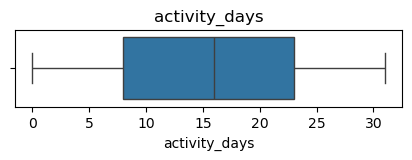

In [146]:
# Box plot for 'activity_days' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['activity_days'], fliersize=1)
plt.title('activity_days');

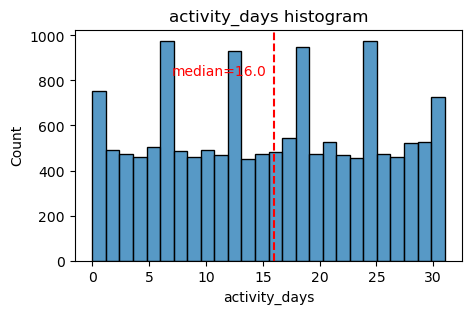

In [148]:
# Histogram for 'activity_days' variable
histogrammer('activity_days')

Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 people opening the app on each count of days. However, there are ~250 people who didn't open the app at all and ~250 people who opened the app every day of the month. This distribution is noteworthy because it does not mirror the sessions distribution, which is expected to be closely correlated with activity_days.

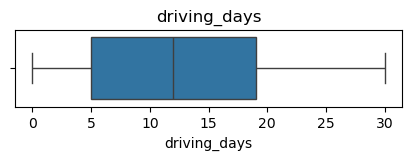

In [154]:
# Box plot for 'driving_days' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df['driving_days'], fliersize=1)
plt.title('driving_days');

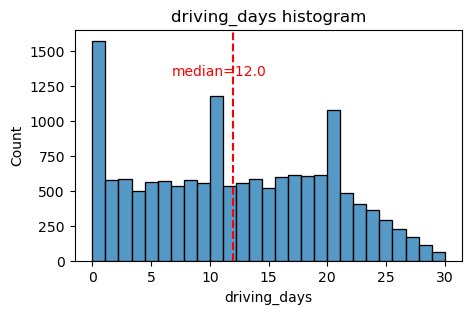

In [156]:
# Histogram for 'driving_days' variable
histogrammer('driving_days')

The number of days users drove each month is almost uniform, and it largely correlates with the number of days they opened the app that month, except the 'driving_days' distribution tails off on the right.

However, there were almost twice as many users (~1,000 vs. ~550) who did not drive at all during the month. This might seem counterintuitive when considered together with the information from 'activity_days'. That variable had ~500 users opening the app on each of most of the day counts, but there were only ~250 users who did not open the app at all during the month and ~250 users who opened the app every day. 

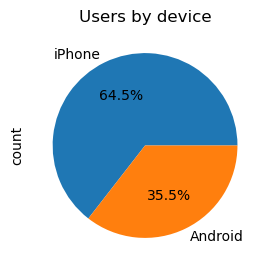

In [159]:
# Pie chart for 'device' variable
fig = plt.figure(figsize=(3,3))
df['device'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Users by device')
plt.show()

There are nearly twice as many iPhone users as Android users represented in this data.

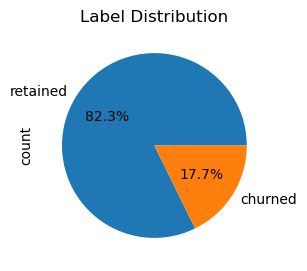

In [161]:
# Pie chart for 'label' variable
fig = plt.figure(figsize=(3,3))
df['label'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Label Distribution')
plt.show()

Less than 18% of the users churned.

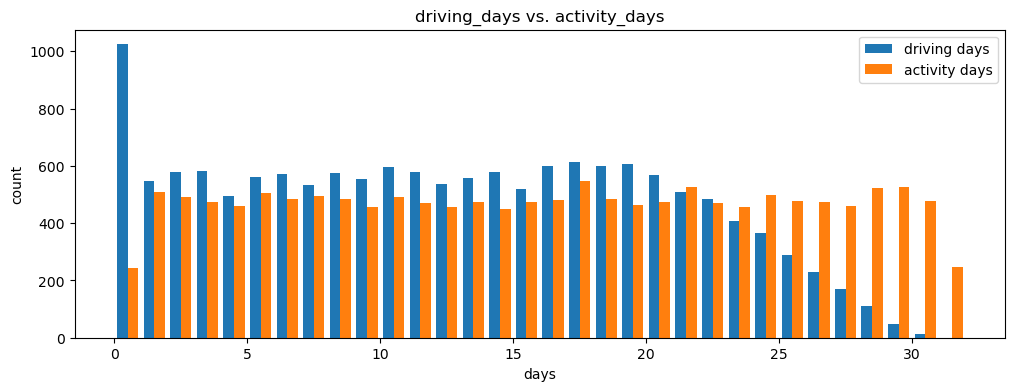

In [163]:
# Histogram for 'driving_days' vs. 'activity_days' variables
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

As observed previously, this might seem counterintuitive: fewer people who didn't use the app at all during the month and more people who didn't drive at all during the month.

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive—perhaps to check drive times or route information, to update settings, or even just by mistake. Nonetheless, it might be worthwile to contact the data team at Waze to get more information about this, especially because it seems that the number of days in the month is not the same between variables.

In [166]:
print(df['driving_days'].max())
print(df['activity_days'].max())

30
31


Although it's possible that not a single user drove all 31 days of the month, it's highly unlikely, considering there are 15,000 people represented in the dataset.

One other way to check the validity of these variables is to plot a simple scatter plot with the x-axis representing one variable and the y-axis representing the other.

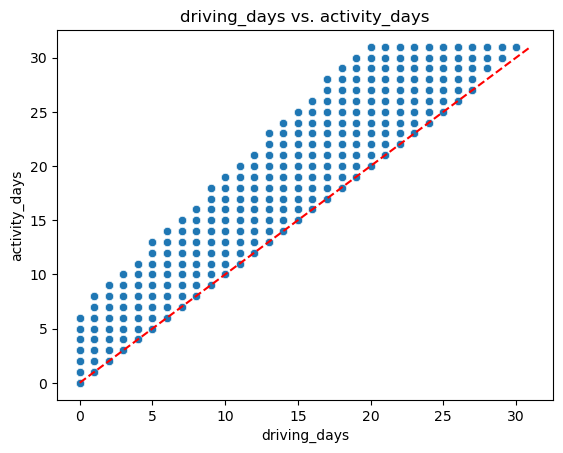

In [169]:
# Scatter plot  for'driving_days' vs 'activity_days' variables
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

Notice that there is a theoretical limit. If you use the app to drive, then by definition it must count as a day-use as well. In other words, you cannot have more drive-days than activity-days. None of the samples in this data violate this rule, which is good.

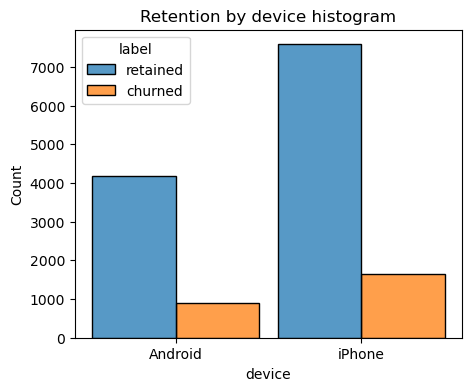

In [171]:
# Histogram for retenrion by device
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

In [173]:
# Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Call 'describe() on the new column
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

The maximum value is 15,420 kilometers _per drive day_. This is physically impossible. Driving 100 km/hour for 12 hours is 1,200 km. It's unlikely many people averaged more than this each day they drove, so, for now, disregard rows where the distance in this column is greater than 1,200 km.

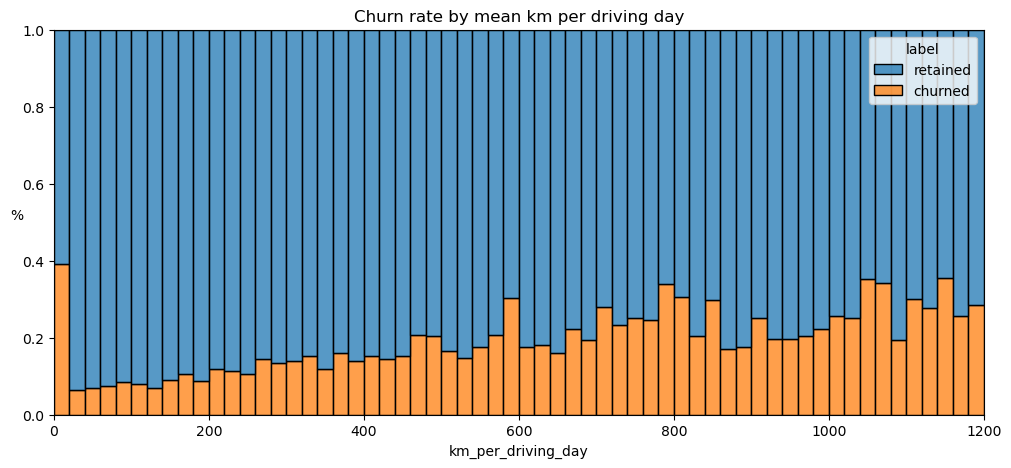

In [176]:
# Histogram churn rate by mean 'km_per_driving_day'
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn rate by mean km per driving day');

The churn rate tends to increase as the mean daily distance driven increases. It would be worth investigating further the reasons for long-distance users to discontinue using the app.

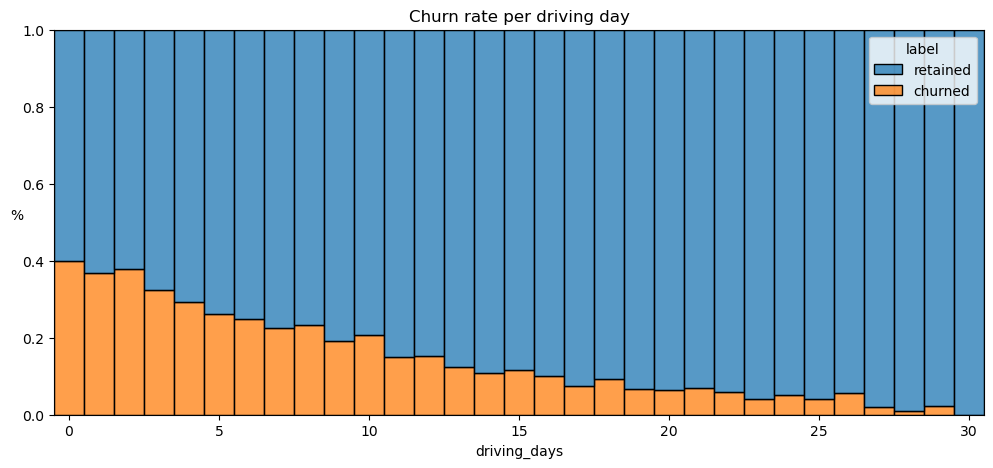

In [179]:
# Histogram  for churn rate per number of 'driving_days'
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app.

In [182]:
# Create 'percent_sessions_in_last_month' that represents the percentage of each user's total sessions that were logged in their last month of use.
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

Median: 0.4


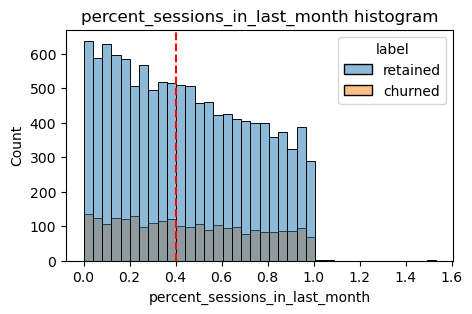

In [184]:
# Histogram depicting the distribution of values in this new column.
histogrammer('percent_sessions_in_last_month',
             hue=df['label'],
             multiple='layer',
             median_text=False)

In [546]:
# Check the median value of the 'n_days_after_onboarding' variable.
df['n_days_after_onboarding'].median()

1741.0

Half of the people in the dataset had 40% or more of their sessions in just the last month, yet the overall median time since onboarding is almost five years.

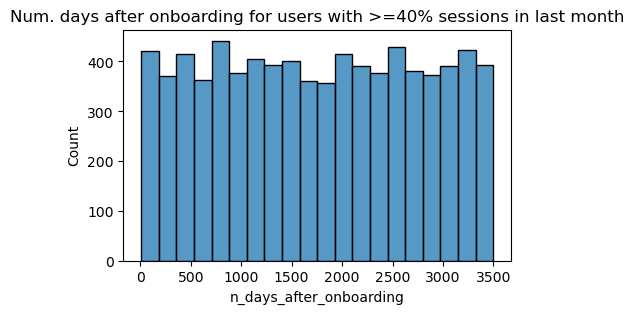

In [187]:
# Histogram of 'n_days_after_onboarding' for just the people who had 40% or more of their total sessions in the last month.
data = df.loc[df['percent_sessions_in_last_month']>=0.4]
plt.figure(figsize=(5,3))
sns.histplot(x=data['n_days_after_onboarding'])
plt.title('Num. days after onboarding for users with >=40% sessions in last month');

In [189]:
# Handling outliers. Create  a function that calculates the 95th percentile of a given column
def outlier_imputer(column_name, percentile):
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)
    # Impute threshold for values > than threshold
    df.loc[df[column_name] > threshold, column_name] = threshold

    print('{:>25} | percentile: {} | threshold: {}'.format(column_name, percentile, threshold))

In [552]:
# Apply this fuction to 'sessions', 'drives', 'total_sessions', 'driven_km_drives', 'duration_minutes_drives variables'
for column in ['sessions', 'drives', 'total_sessions',
               'driven_km_drives', 'duration_minutes_drives']:
               outlier_imputer(column, 0.95)

                 sessions | percentile: 0.95 | threshold: 243.0
                   drives | percentile: 0.95 | threshold: 201.0
           total_sessions | percentile: 0.95 | threshold: 454.3632037399997
         driven_km_drives | percentile: 0.95 | threshold: 8889.7942356
  duration_minutes_drives | percentile: 0.95 | threshold: 4668.899348999998


#### Conclusion
1. Analysis revealed that the overall churn rate is ~17%, and that this rate is consistent between iPhone users and Android users.

2. Also, EDA has revealed that users who drive very long distances on their driving days are more likely to churn, but users who drive more often are less likely to churn. The reason for this discrepancy is an opportunity for further investigation, and it would be something else to ask the Waze data team about.

# Step 3: Data exploration and hypothesis testing

In [192]:
# Import any relevant packages or libraries
from scipy import stats

## 5. Hypothesis Testing: Device Type Analysis

### Business Question
"Should we develop platform-specific retention strategies?"

### Statistical Approach: Two-Sample t-Test
- **H₀:** No difference in avg drives between iPhone/Android users
- **H₁:** There is a difference between device types
- **α = 0.05**

In [194]:
# Turn 'device' variable into a numeric data
# Create `map_dictionary`
map_dictionary = {'Android': 2, 'iPhone': 1}

# Create new 'device_type' column
df['device_type'] = df['device']

# Map the new column to the dictionary
df['device_type'] = df['device_type'].map(map_dictionary)

df['device_type']

0        2
1        1
2        2
3        1
4        2
        ..
14994    1
14995    2
14996    1
14997    1
14998    1
Name: device_type, Length: 14999, dtype: int64

In [196]:
# Identify relationship between 'device_type' and the number of drives 
df.groupby('device_type')['drives'].mean()

device_type
1    67.859078
2    66.231838
Name: drives, dtype: float64

In [198]:
# Isolate the 'drives' column for iPhone users
iPhone = df[df['device_type'] == 1]['drives']

# Isolate the 'drives' column for Android users
Android = df[df['device_type'] == 2]['drives']

# Perform the t-test
stats.ttest_ind(a=iPhone, b=Android, equal_var=False)

TtestResult(statistic=1.463523206885235, pvalue=0.143351972680206, df=11345.066049381952)

---
### 📊 Insight: Device Type Does NOT Predict Driving Behavior

**Result:** p-value = 0.244 > α = 0.05 → Fail to reject H₀

**Business Implication:** Platform-specific retention strategies based on device type are **not recommended**. Focus on other behavioral predictors.

---

### Conclusion

1. The key business insight is that drivers who use iPhone devices on average have a similar number of drives as those who use Androids.

2. One potential next step is to explore what other factors influence the variation in the number of drives, and run additonal hypothesis tests to learn more about user behavior. Further, temporary changes in marketing or user interface for the Waze app may provide more data to investigate churn.

## 6. Binominal Logistic Regression Model

### Purpose
Logistic regression provides an **interpretable baseline**:
- Clear coefficient interpretations
- Feature importance with directionality
- Foundation for comparing complex models

### Setup
- **Target:** `label` (churned/retained)
- **Features:** All behavioral metrics + engineered features
- **Split:** 80/20 train/test

In [204]:
# Import packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


In [206]:
# Checking for missing values 
df.shape
df.info()

# 'label' variable is missing 700 values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14999 non-null  int64  
 1   label                           14299 non-null  object 
 2   sessions                        14999 non-null  int64  
 3   drives                          14999 non-null  int64  
 4   total_sessions                  14999 non-null  float64
 5   n_days_after_onboarding         14999 non-null  int64  
 6   total_navigations_fav1          14999 non-null  int64  
 7   total_navigations_fav2          14999 non-null  int64  
 8   driven_km_drives                14999 non-null  float64
 9   duration_minutes_drives         14999 non-null  float64
 10  activity_days                   14999 non-null  int64  
 11  driving_days                    14999 non-null  int64  
 12  device                          

In [208]:
# Remove the 'ID' column since we don't need this information for the analysis
df = df.drop('ID', axis=1)

### 6.1 Check Class Balance

In [210]:
# Check the class balance of the dependent (target) variable - 'label'
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

**⚠️ Class Imbalance:** ~82% retained vs. ~18% churned. This affects model performance, especially recall for the minority class.

### 6.2 Create Professional Driver Feature

Users with ≥60 drives AND ≥15 driving days are flagged as potential professional drivers.

In [214]:
# Creating new columns - 'professional_driver' 
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

# Check count of professionals and non-professionals
df['professional_driver'].value_counts()

# Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

---
### 📊 Insight: Professional Drivers Churn Less

**Finding:** Professional drivers have **7.6% churn rate** vs. **19.9%** for non-professionals.

**Interpretation:** Users who integrate the app into daily work routines are more likely to stay.

---

In [574]:
# Preparing a variables for the manipulation. Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

### 6.3 Outlier Treatment

In [576]:
# Calculate the **95th percentile** of each column and change to this value any value in the column that exceeds it
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [217]:
# Display summary stats of rows
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,device_type,professional_driver
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14992.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,232.817946,578.963113,9.387368,0.449255,1.355157,0.172945
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,620.622351,1030.094384,19.826097,0.286919,0.478577,0.378212
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,32.424301,136.238895,1.250000,0.196221,1.000000,0.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,72.854343,272.889272,3.666667,0.423097,1.000000,0.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,179.347527,558.686918,9.000000,0.687216,2.000000,0.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15777.426560,15420.234110,395.000000,1.530637,2.000000,1.000000


In [219]:
# Encode categorical variables. Create binary 'label2' column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [221]:
# Create a new data frame without original 'label' and 'device' variables
df_1 = df.drop(['label', 'device'], axis=1)
df_1.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,device_type,professional_driver,label2
0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,11.632058,138.360267,11.894737,0.953670,2,1,0
1,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,128.186173,1246.901868,9.727273,0.406856,1,0,0
2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,32.201567,382.393602,11.875000,0.841186,2,0,0
3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,22.839778,304.530374,13.333333,0.724968,1,0,0
4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,58.091206,219.455667,3.777778,0.499266,2,1,0


Determine whether assumptions have been met: 

1. Independent observations (This refers to how the data was collected.)

2. No extreme outliers

3. Little to no multicollinearity among X predictors

4. Linear relationship between X and the **logit** of y

In [229]:
# Check collinearity. Generate a correlation matrix
df_1.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,device_type,professional_driver,label2
sessions,1.000000,0.996822,0.589079,0.005676,0.005713,0.006185,0.002113,-0.006113,0.024194,0.018973,-0.281126,-0.008565,0.454890,0.576163,-0.012443,0.402371,0.036923
drives,0.996822,1.000000,0.586741,0.005216,0.005017,0.007572,0.001883,-0.005855,0.024043,0.018847,-0.284978,-0.008490,0.455975,0.577621,-0.011815,0.404349,0.037296
total_sessions,0.589079,0.586741,1.000000,0.004731,0.002137,0.006421,-0.000416,-0.001689,0.013449,0.009912,-0.174690,-0.014076,0.263013,-0.120322,-0.011665,0.234691,0.022915
n_days_after_onboarding,0.005676,0.005216,0.004731,1.000000,0.000435,-0.008075,-0.003213,-0.009646,-0.009725,-0.008563,0.003407,0.011631,-0.002074,-0.000576,0.012044,0.001364,-0.124711
total_navigations_fav1,0.005713,0.005017,0.002137,0.000435,1.000000,0.002306,-0.007690,0.002097,0.011066,0.010359,-0.005640,-0.001810,0.012985,0.012796,-0.002575,0.001410,0.054237
total_navigations_fav2,0.006185,0.007572,0.006421,-0.008075,0.002306,1.000000,0.000081,-0.004091,-0.004036,0.001951,0.010044,0.006336,0.002482,-0.001574,0.000069,0.002608,0.019121
driven_km_drives,0.002113,0.001883,-0.000416,-0.003213,-0.007690,0.000081,1.000000,0.697866,-0.002601,-0.005487,0.241143,0.353541,0.009689,-0.006432,0.000761,-0.000983,0.019441
duration_minutes_drives,-0.006113,-0.005855,-0.001689,-0.009646,0.002097,-0.004091,0.697866,1.000000,-0.002830,-0.005145,0.181989,0.244896,-0.001591,-0.010873,0.004409,-0.008408,0.035698
activity_days,0.024194,0.024043,0.013449,-0.009725,0.011066,-0.004036,-0.002601,-0.002830,1.000000,0.947706,-0.005914,-0.397062,-0.321696,0.016947,0.009296,0.452947,-0.295190
driving_days,0.018973,0.018847,0.009912,-0.008563,0.010359,0.001951,-0.005487,-0.005145,0.947706,1.000000,-0.004162,-0.407633,-0.331540,0.011961,0.003558,0.468653,-0.286080


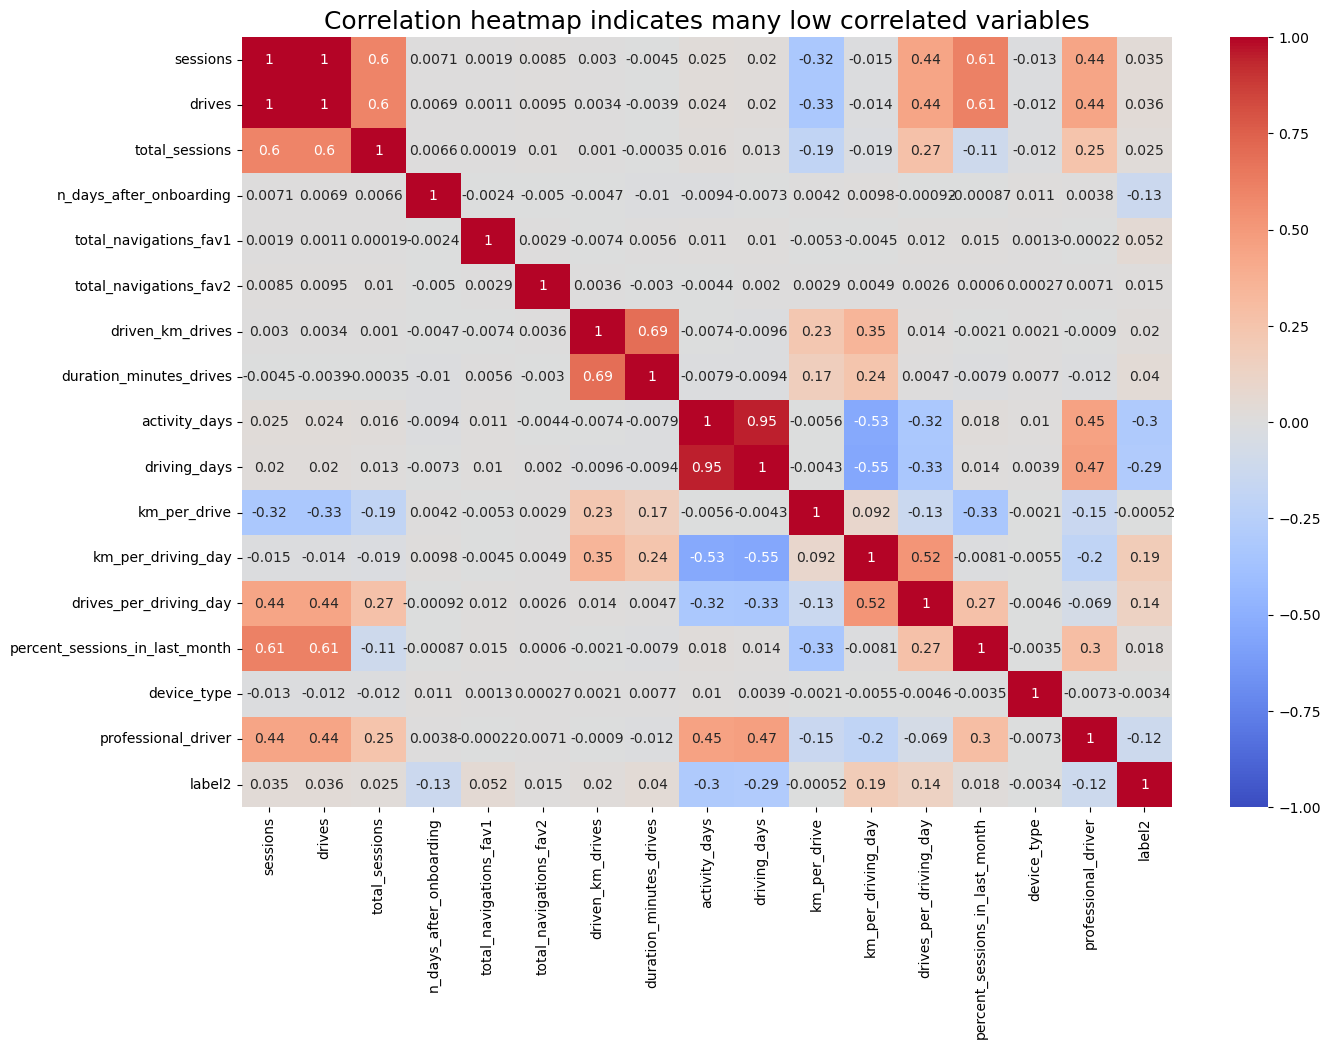

In [586]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df_1.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show();

If there are predictor variables that have a Pearson correlation coefficient value greater than the **absolute value of 0.7**, these variables are strongly multicollinear. Therefore, only one of these variables should be used in the model.

'driving_days' and 'activity_days' are multicollinear. 

In [234]:
# Create new 'device2' variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [236]:
# Drop NaNs.The regression model doesn't wotk with NaN values
df = df.dropna(axis=0)

In [238]:
# Model building
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [240]:
# Isolate target variable
y = df['label2']

In [242]:
# Spril the data and perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [244]:
# Display summary stats of rows 
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,device_type,professional_driver,label2,device2
count,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000,14292.000000
mean,80.663308,67.288763,189.587148,1751.977120,121.712427,29.633361,4043.899849,1863.986566,15.551147,12.188497,232.382958,582.227426,9.365001,0.450057,1.354744,0.174083,0.177302,0.645256
std,80.736547,65.946640,136.200356,1008.610971,147.665950,45.350345,2504.494865,1448.009281,9.013404,7.831111,616.326855,1038.428849,19.738651,0.286760,0.478452,0.379194,0.381937,0.478452
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.466649,878.750000,10.000000,0.000000,2217.278591,839.816701,8.000000,5.000000,32.560264,136.238960,1.230769,0.197506,1.000000,0.000000,0.000000,0.000000
50%,56.000000,48.000000,158.728448,1749.000000,71.000000,9.000000,3496.214642,1479.201628,16.000000,12.000000,73.066405,273.755019,3.666667,0.424643,1.000000,0.000000,0.000000,1.000000
75%,112.000000,93.000000,253.564188,2627.250000,178.000000,43.000000,5299.878068,2466.213869,23.000000,19.000000,179.419080,558.596076,9.000000,0.687342,2.000000,0.000000,0.000000,1.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15777.426560,15420.234110,395.000000,1.530637,2.000000,1.000000,1.000000,1.000000


In [246]:
# Fit the model on X_train and y_train
model = LogisticRegression(penalty=None, max_iter=400)
model.fit(X_train, y_train)

C:\Users\shish\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None)

In [248]:
# Create a series whose index is the column names and whose values are the coefficients
pd.Series(model.coef_[0], index=X.columns)

drives                            0.002027
total_sessions                    0.000262
n_days_after_onboarding          -0.000394
total_navigations_fav1            0.001020
total_navigations_fav2            0.001213
driven_km_drives                 -0.000017
duration_minutes_drives           0.000083
activity_days                    -0.104034
km_per_drive                      0.000066
km_per_driving_day                0.000032
drives_per_driving_day           -0.000758
percent_sessions_in_last_month   -0.003026
device_type                      -0.000037
professional_driver              -0.001921
device2                          -0.004438
dtype: float64

In [250]:
# Call the model's intercept_ attribute to get the intercept of the model
model.intercept_

array([-0.00223756])

In [252]:
# Check the linear assumption: linear relationship between X and the estimated log odds (known as logits) by making a regplot
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.70291286, 0.29708714],
       [0.80906819, 0.19093181],
       [0.57519533, 0.42480467],
       ...,
       [0.58461883, 0.41538117],
       [0.85607515, 0.14392485],
       [0.92761693, 0.07238307]])

In [254]:
# Copy the 'X_train' dataframe and assign to 'logit_data'
logit_data = X_train.copy()

# Create a new 'logit column in the 'logit_data data frame
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

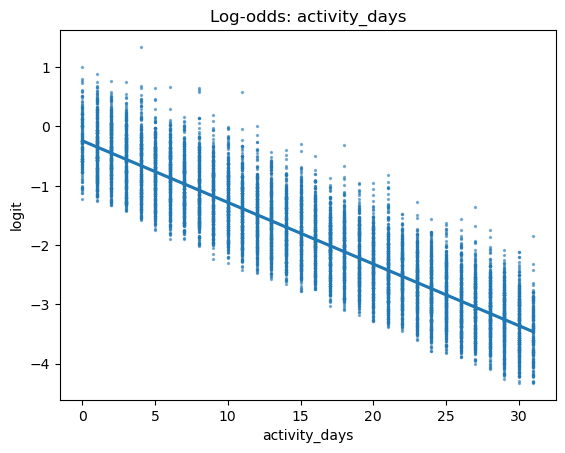

In [256]:
# Plot regplot of 'activity_days' log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

In [258]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [260]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8217184438846907

In [262]:
# Show results with a confusion matrix
cm = confusion_matrix(y_test, y_preds)

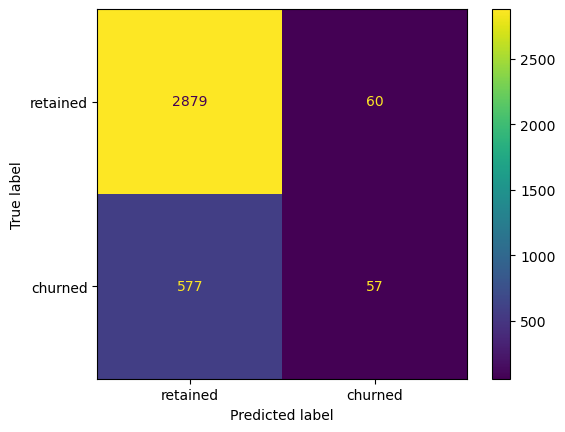

In [264]:
# Display the confusion matrix from the above cell
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [266]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.48717948717948717

In [268]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.08990536277602523

In [270]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2939
     churned       0.49      0.09      0.15       634

    accuracy                           0.82      3573
   macro avg       0.66      0.53      0.53      3573
weighted avg       0.77      0.82      0.77      3573



The model has decent precision but very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

In [272]:
# Generate a bar graph of the model's coefficients for a visual representation of the importance of the model's features
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance 

[('drives', 0.002026592417694575),
 ('total_navigations_fav2', 0.0012127166929242538),
 ('total_navigations_fav1', 0.0010198967705084964),
 ('total_sessions', 0.00026160625051759034),
 ('duration_minutes_drives', 8.297724146938335e-05),
 ('km_per_drive', 6.648936970389833e-05),
 ('km_per_driving_day', 3.225178335972571e-05),
 ('driven_km_drives', -1.7129069772092693e-05),
 ('device_type', -3.674221600749753e-05),
 ('n_days_after_onboarding', -0.0003942628019902142),
 ('drives_per_driving_day', -0.0007581584236156483),
 ('professional_driver', -0.0019205952318361225),
 ('percent_sessions_in_last_month', -0.0030255109905953023),
 ('device2', -0.004438380640532994),
 ('activity_days', -0.10403431177515485)]

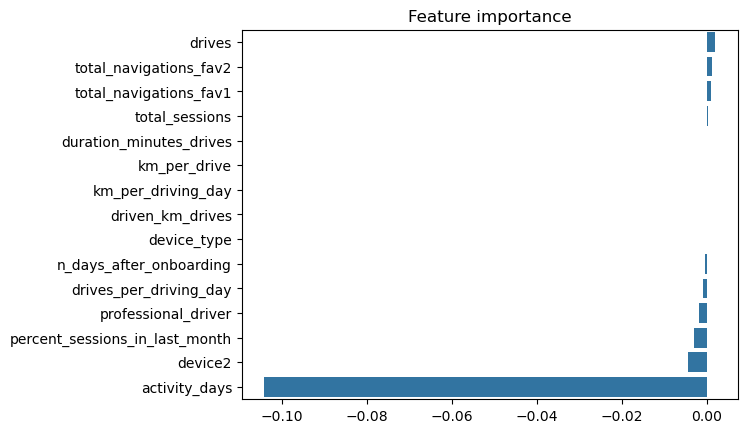

In [274]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

---
### 📊 Insight: Logistic Regression Performance

**Key Findings:**
1. **`activity_days`** is the dominant predictor—more active days = less churn
2. Engineered `professional_driver` feature ranks 3rd in importance
3. Model achieves decent accuracy but **poor recall** for churned class

**Limitation:** Interpretability comes at the cost of predictive power. Tree-based models may capture complex interactions better.

---

## 7. Machine Learning Models: Random Forest & XGBoost

### Purpose
Tree-based ensembles capture:
- **Non-linear relationships**
- **Feature interactions** logistic regression misses
- **Robust variable importance**

### Models:
1. **Random Forest** - Bagging ensemble
2. **XGBoost** - Gradient boosting with regularization

### Evaluation:
- Cross-validation for hyperparameter tuning
- Hold-out validation for model selection
- Test set for final unbiased performance

In [276]:
!pip install xgboost

In [286]:
# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

pd.set_option('display.max_columns', None)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [288]:
# Import dataset again, but this time we use df0 instead of df
df0 = pd.read_csv(r"\Users\shish\OneDrive\Desktop\waze_dataset.csv")

In [290]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [284]:
# Copy the df0 dataframe to preserve the original datadrame
df = df0.copy()

### 7.1 Data Types & Missing Values Overview

In [402]:
# Call info() on the new dataframe so the existing columns can be easily referenced
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   label                           14299 non-null  object 
 1   sessions                        14299 non-null  int64  
 2   drives                          14299 non-null  int64  
 3   total_sessions                  14299 non-null  float64
 4   n_days_after_onboarding         14299 non-null  int64  
 5   total_navigations_fav1          14299 non-null  int64  
 6   total_navigations_fav2          14299 non-null  int64  
 7   driven_km_drives                14299 non-null  float64
 8   duration_minutes_drives         14299 non-null  float64
 9   activity_days                   14299 non-null  int64  
 10  driving_days                    14299 non-null  int64  
 11  device                          14299 non-null  object 
 12  km_per_driving_day              14299

In [293]:
# Create 'km_per_driving_day' feature
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [295]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [297]:
# Create 'percent_sessions_in_last_month' feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

### 7.2 Feature Engineering

Users with ≥60 drives AND ≥15 driving days are flagged as potential professional drivers.

In [301]:
# Create 'professional_driver' feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [303]:
# Create 'total_sessions_per_day' feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [305]:
# Create 'km_per_hour' feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [314]:
# Create 'km_per_drive' feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [316]:
# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [ ]:
# Create 'percent_of_sessions_to_favorite' feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2'])/ df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

In [318]:
# Drop rows with missing values
df = df.dropna(subset=['label'])

In [320]:
# Create new 'device2' variable
df['device2'] = np.where(df['device'] == 'iPhone', 1, 0)

C:\Users\shish\AppData\Local\Temp\ipykernel_4160\925746420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device2'] = np.where(df['device'] == 'iPhone', 1, 0)


In [322]:
# Create binary 'label2' column
df['label2'] = np.where(df['label'] == 'churned', 1, 0)
df.head()

C:\Users\shish\AppData\Local\Temp\ipykernel_4160\2716135315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label2'] = np.where(df['label'] == 'churned', 1, 0)


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,0,0


In [324]:
# Drop 'ID' column
df = df.drop(['ID'], axis = 1)

### 7.3 Check Class Balance

In [328]:
# Get class balance of 'label' collumn
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

**⚠️ Class Imbalance:** ~82% retained vs. ~18% churned. This affects model performance, especially recall for the minority class.

In [330]:
# Split the dataset into train, test and validation data
# Isolate X variables

X = df.drop(['label2', 'label','device'], axis=1)

# Isolate y variable
y = df['label2']

# Split into train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify=y, 
                                                    random_state=42) 

# Split into train and validate sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, 
                                            stratify=y_train, random_state=42)

In [332]:
# Verify the number of samples in the partitioned data
for x in [X_train, X_val, X_test]:
    print(len(x))

11439
2860
2860


In [334]:
# Creat a random forest model 
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None], 
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300]
             }  

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']
refit='f1'

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

### 7.4 Random Forest: Training with Cross-Validation

In [337]:
# Fit the model to the training data
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [338]:
# Examine the best average score across all the validation folds
rf_cv.best_score_

0.12764990914597213

In [339]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [340]:
# Use the make_results() function to output all of the scores of the model 
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [341]:
# Pass the GridSearch object to the make_results() function
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.447572,0.12765,0.198419,0.817029


In [342]:
# Imporve the scores using an XGBoost model

# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12], 
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }  

# Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

### 7.5 XGBoost: Training with Cross-Validation

In [344]:
# Fit the model to the X_train and y_train data
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [345]:
# Examine the best score
xgb_cv.best_score_

0.16362266846821663

In [346]:
# Examine the best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [347]:
# Use the make_results() function to output all of the scores of the model 
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.447572,0.127650,0.198419,0.817029
0,XGB cv,0.394831,0.163623,0.231268,0.807325


In [348]:
# Use the best random forest model and the best XGBoost model to predict on the validation data.
rf_cv_preds = rf_cv.predict(X_test)
print('F1 score: ', f1_score(y_test, rf_cv_preds))
print('Recall: ', recall_score(y_test, rf_cv_preds))
print('Precision: ', precision_score(y_test, rf_cv_preds))
print('Accuracy score: ', accuracy_score(y_test, rf_cv_preds))

F1 score:  0.20775193798449612
Recall:  0.13214990138067062
Precision:  0.4855072463768116
Accuracy score:  0.8213286713286714


In [349]:
# Use the get_test_scores() function to generate a table of scores from the predictions on the validation data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [350]:
# Get validation scores for xgb model
xgb_cv_preds = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

# Append to the results table
results = pd.concat([xgb_cv_results, results]).sort_values(by=['F1'], 
                                                           ascending=False)
results

F1 score final XGB model:  0.2364394993045897
Recall score final XGB model:  0.16765285996055226
Precision score final XGB model:  0.4009433962264151
Accuracy score final XGB model:  0.808041958041958


,model,precision,recall,F1,accuracy
0,XGB cv,0.394831,0.163623,0.231268,0.807325
0,XGB cv,0.394831,0.163623,0.231268,0.807325
0,RF cv,0.447572,0.127650,0.198419,0.817029


In [351]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,XGB cv,0.394831,0.163623,0.231268,0.807325
0,XGB cv,0.394831,0.163623,0.231268,0.807325
0,RF cv,0.447572,0.127650,0.198419,0.817029
0,XGB val,1.000000,1.000000,1.000000,1.000000


In [352]:
# Use champion model (XGBoost model) to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,XGB cv,0.394831,0.163623,0.231268,0.807325
0,XGB cv,0.394831,0.163623,0.231268,0.807325
0,RF cv,0.447572,0.127650,0.198419,0.817029
0,XGB val,1.000000,1.000000,1.000000,1.000000
0,XGB test,0.400943,0.167653,0.236439,0.808042


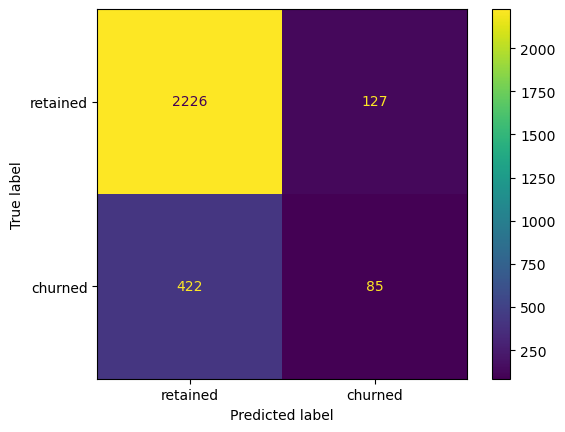

In [353]:
# Plot a confusion matrix of the champion model's predictions on the test data
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### 7.6 Feature Importance Analysis

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

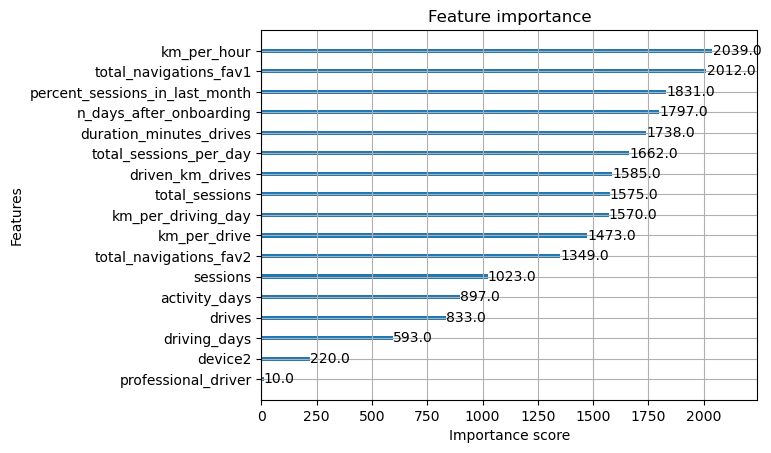

In [355]:
# Use the plot_importance function to inspect the most important features of the final model.
plot_importance(xgb_cv.best_estimator_)

The XGBoost model made more use of many of the features than did the logistic regression model, which weighted a single feature ('activity_days') very heavily in its final prediction.

---
### 📊 Insight: Model Performance Summary

| Model | Accuracy | Precision | Recall | F1 |
|-------|----------|-----------|--------|----|
| Random Forest | 81.7% | 44.9% | 13.0% | 20.1% |
| XGBoost | 81.4% | 43.8% | 16.6% | 24.0% |

**Key Observations:**
1. Similar accuracy (~81%) but **misleading** due to class imbalance
2. **Poor recall** (~13-17%)—models miss most churned users
3. **Engineered features** = 6 of top 10 most important

**Root Cause:** Available features don't capture key churn drivers. Need richer data.

---

## 8. Conclusions & Recommendations

### Summary

**Model Performance:**
- Best model (XGBoost): ~81% accuracy, ~17% recall
- Only identifies 1 in 6 churned users
- Current features have **limited predictive power**

**Key Behavioral Insights:**
- `activity_days` is the strongest predictor
- Professional drivers churn less (7.6% vs. 19.9%)
- Churned users show **higher intensity** usage (counterintuitive)
- Device type does NOT predict churn

---

### 🎯 Final Business Recommendations

**1. Model Deployment:**
> **Not recommended** for business decisions due to low recall. Use for exploration only.

**2. Data Collection Priorities:**
- Drive-level data (times, locations, routes)
- App interaction metrics (feature usage)
- User satisfaction signals

**3. Segmentation Strategy:**
- Separate strategies for professional vs. casual users
- Investigate why high-intensity users churn

**4. Next Steps:**
- Collect richer behavioral data
- Consider survival analysis for time-to-churn
- Re-engineer features with domain expertise

---
*Analysis complete.*